In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%matplotlib inline

# Ejemplo de entrenamiento de CAE sobre MNIST 2

Este notebook tiene dos objetivos:

* _Entrenamiento a partir de imágenes PNG_: uno de los problemas encontrados a la hora de entrenar una red con imágenes es el tamaño del conjunto de entrenamiento. Una gran cantidad de imágenes de resolución media pueden saturar la memoria RAM de la máquina y parar el programa. Para evitar esto _Keras_ tiene métodos implentados que hacen el entrenamiento por _batches_ leyendo únicamente un subconjunto de imágenes en cada momento. El primer objetivo es analizar esta posibilidad.

* _Error de reconstrucción como predicción:_ además de para extraer variables latentes se le pueden dar otros usos al Autoencoder Convolucional. En este caso se pretende entrenar dos CAE con subconjuntos de dígitos distintos (eg. 0,1,2,3,4 vs 5,6,7,8,9), y sobre el conjunto de test calcular el error de reconstrucción de cada imagen en ambas redes. Conceptualmente un número del primer conjunto tendrá un menor error de reconstrucción con el primer modelo que con el segundo.

In [7]:
from model.cae import CAE

from utils import plot_paired_imgs
from utils import plot_sample_imgs
from utils import read_images

import os

import numpy as np
import pandas as pd

from tqdm import tqdm_notebook

In [8]:
from datetime import datetime

In [9]:
from keras.callbacks import TensorBoard
from keras.preprocessing.image import ImageDataGenerator

In [19]:
DATA_PATH = '/Users/portizdegalisteo/TFM_Data/mnist'
PNG_PATH = os.path.join(DATA_PATH, 'png')

__Lectura de datos__

Se leen DataFrames que contienen el nomnbre de cada fichero .png de su imagen correspondiente.

In [16]:
train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'), sep='|')
test_df = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'), sep='|')

In [20]:
train_df.head(3)

,label,filename
0,5,train_00000.png
1,0,train_00001.png
2,4,train_00002.png


In [21]:
test_df.head(3)

,label,filename
0,7,test_00000.png
1,2,test_00001.png
2,1,test_00002.png


__División de conjuntos__

Se subdividen los conjuntos de train/test en dos conjuntos, los de los dígitos menores que 5 y los mayores o iguales que 5. Se puede comprobar que ambos conjuntos tienen  un número similar de muestras, si no fuera el caso sería recomentable ya que la calidad de los modelos se puede ver influenciada por la cantidad de muestras de entrenamiento.

In [31]:
train_sub_5_df = train_df[train_df['label'] < 5]
train_over_5_df = train_df[train_df['label'] >= 5]

In [32]:
test_sub_5_df = test_df[test_df['label'] < 5]
test_over_5_df = test_df[test_df['label'] >= 5]

In [33]:
len(train_sub_5_df), len(test_sub_5_df)

(25538, 5139)

In [34]:
len(train_over_5_df), len(test_over_5_df)

(24462, 4861)

## Generador de Imágenes

Para realizar el entrenamiento por _batches_ que se menciona al incicio de este notebook se utiliza la clase _ImageDataGenerator_, esta sirve para crear un lector de imágenes y evitar cargar todas a la vez en memoria. Esta clase tiene un método *flow_from_dataframe* donde se crea el lector de imágenes a partir de los nombres de ficheros que haya en un DataFrame.

También permite crear un lector de imágenes para el conjunto de validación o, por ejemplo, redimensionar todas las imágenes al un tamaño concreto *target_size*, esto sería muy util si las imagenes disponibles no tuviesen dimensiones constantes. En este caso mantenemos las originales 28x28.

**IMPORTANTE**: es necesario reescalar el rango de valores de imágenes entre 255 ya que por defecto cuando see leen las imágenes RGB los valores de los píxeles van de 0 a 255, el nivel en la escala de 8 bits. Con esos rangos de valores y los *learning rate* que hay por defecto el modelo sería incapaz de aprender.

__Train__

In [37]:
len(train_sub_5_df)

25538

In [41]:
train_datagen = ImageDataGenerator(validation_split=0.2, rescale=1/255)

# Sub 5
train_sub_5_generator = train_datagen.flow_from_dataframe(train_sub_5_df, directory=PNG_PATH + '/', x_col='filename', 
                                                          target_size=(28, 28), color_mode='rgb', class_mode='input',
                                                          batch_size=32, subset='training', seed=1993)

valid_sub_5_generator = train_datagen.flow_from_dataframe(train_sub_5_df, directory=PNG_PATH, x_col='filename', 
                                                          target_size=(28, 28), color_mode='rgb', class_mode='input', 
                                                          batch_size=32, subset='validation', seed=1993)

# Over 5
train_over_5_generator = train_datagen.flow_from_dataframe(train_over_5_df, directory=PNG_PATH + '/', x_col='filename', 
                                                           target_size=(28, 28), color_mode='rgb', class_mode='input', 
                                                           batch_size=32, subset='training', seed=1993)

valid_over_5_generator = train_datagen.flow_from_dataframe(train_over_5_df, directory=PNG_PATH, x_col='filename', 
                                                           target_size=(28, 28), color_mode='rgb', class_mode='input', 
                                                           batch_size=32, subset='validation', seed=1993)

Found 20431 images.
Found 5107 images.
Found 19570 images.
Found 4892 images.


__Test__

In [42]:
test_datagen = ImageDataGenerator(rescale=1/255)

# Sub 5
test_sub_5_generator = test_datagen.flow_from_dataframe(test_sub_5_df, directory=PNG_PATH, x_col='filename', 
                                                        target_size=(28, 28), color_mode='rgb', class_mode='input', 
                                                        batch_size=1, seed=1993)
# Over 5
test_over_5_generator = test_datagen.flow_from_dataframe(test_over_5_df, directory=PNG_PATH, x_col='filename', 
                                                         target_size=(28, 28), color_mode='rgb', class_mode='input', 
                                                         batch_size=1, seed=1993)

Found 5139 images.
Found 4861 images.


## Entrenamiento

El diseño de la arquitectura del CAE se utiliza un número bajo de variables latentes. La idea detrás de esto es que todas las imágenes de dígitos tienen propiedades muy similares (bordes, color...) que podrían hacer que un CAE entrenado con unos dígitos sea válido para otros. Al un número pequeño de variables latentes el error de reconstrucción será mayor pero se está forzando al modelo a ser más específico. En este caso lo importante no es minimizar el error de reconstrucción si no maximizar la diferencia de error de un modelo respecto del otro.

In [87]:
cae_sub_5 = CAE(input_shape=(28, 28, 3), latent_features=10, filters=[8,16], path='/tmp/model_ov5')
cae_over_5 = CAE(input_shape=(28, 28, 3), latent_features=10, filters=[8,16], path='/tmp/model_sub5')

In [88]:
tb = TensorBoard(log_dir='../logs/mnist_sub_5',
                 write_grads=True, write_images=True, histogram_freq=0)

cae_sub_5.model.fit_generator(generator = train_sub_5_generator, 
                              validation_data = valid_sub_5_generator,
                              steps_per_epoch = len(train_sub_5_generator),
                              validation_steps = len(valid_sub_5_generator),
                              epochs = 10, 
                              callbacks = [tb])

cae_sub_5.save()

Epoch 1/10
639/639 [==============================] - 28s 43ms/step - loss: 0.0592 - val_loss: 0.0376
Epoch 2/10
639/639 [==============================] - 27s 43ms/step - loss: 0.0342 - val_loss: 0.0313
Epoch 3/10
639/639 [==============================] - 26s 41ms/step - loss: 0.0308 - val_loss: 0.0296
Epoch 4/10
639/639 [==============================] - 28s 44ms/step - loss: 0.0291 - val_loss: 0.0284
Epoch 5/10
639/639 [==============================] - 27s 43ms/step - loss: 0.0281 - val_loss: 0.0275
Epoch 6/10
639/639 [==============================] - 28s 44ms/step - loss: 0.0272 - val_loss: 0.0270
Epoch 7/10
639/639 [==============================] - 27s 43ms/step - loss: 0.0266 - val_loss: 0.0262
Epoch 8/10
639/639 [==============================] - 27s 43ms/step - loss: 0.0261 - val_loss: 0.0260
Epoch 9/10
639/639 [==============================] - 28s 44ms/step - loss: 0.0257 - val_loss: 0.0251
Epoch 10/10
639/639 [==============================] - 28s 43ms/step - loss: 0.025

In [89]:
tb = TensorBoard(log_dir='../logs/mnist_over_5', 
                 write_grads=True, write_images=True, histogram_freq=0)

cae_over_5.model.fit_generator(generator = train_over_5_generator, 
                              validation_data = valid_over_5_generator,
                              steps_per_epoch = len(train_over_5_generator),
                              validation_steps = len(valid_over_5_generator),
                              epochs = 10, 
                              callbacks = [tb])

cae_over_5.save()

Epoch 1/10
612/612 [==============================] - 27s 44ms/step - loss: 0.0610 - val_loss: 0.0443
Epoch 2/10
612/612 [==============================] - 26s 42ms/step - loss: 0.0384 - val_loss: 0.0343
Epoch 3/10
612/612 [==============================] - 26s 42ms/step - loss: 0.0332 - val_loss: 0.0315
Epoch 4/10
612/612 [==============================] - 26s 43ms/step - loss: 0.0311 - val_loss: 0.0300
Epoch 5/10
612/612 [==============================] - 29s 47ms/step - loss: 0.0298 - val_loss: 0.0285
Epoch 6/10
612/612 [==============================] - 25s 42ms/step - loss: 0.0288 - val_loss: 0.0283
Epoch 7/10
612/612 [==============================] - 25s 41ms/step - loss: 0.0280 - val_loss: 0.0272
Epoch 8/10
612/612 [==============================] - 25s 41ms/step - loss: 0.0273 - val_loss: 0.0269
Epoch 9/10
612/612 [==============================] - 25s 41ms/step - loss: 0.0268 - val_loss: 0.0264
Epoch 10/10
612/612 [==============================] - 25s 42ms/step - loss: 0.026

## Evaluación

Se comprueba como los errores de reconstrucción son aproximadamente dos veces más cuando se utiliza el CAE que no corresponde, esto demuestra la validez de la idea. Es ahora es posible predecir si un número es mayor o igual que 5 comparando los errores de reconstrucción de ambos CAE.

**CAE < 5** vs **Digitos < 5**

In [248]:
cae_sub_5.model.evaluate_generator(test_sub_5_generator, steps=len(test_sub_5_generator))

0.024958572241026957

**CAE < 5** vs **Digitos >= 5**

In [250]:
cae_sub_5.model.evaluate_generator(test_over_5_generator, steps=len(test_over_5_generator))

0.04827071048416668

**CAE >= 5** vs **Digitos >= 5**

In [90]:
cae_over_5.model.evaluate_generator(test_over_5_generator, steps=len(test_over_5_generator))

0.02619810340317942

**CAE >= 5** vs **Digitos < 5**

In [93]:
cae_over_5.model.evaluate_generator(test_sub_5_generator, steps=len(test_sub_5_generator))

0.048301321839635154

__Ejemplos__

Las siguientes figuras muestran ejemplos de las imágenes originales y sus reconstrucciones con cada uno de los dos CAEs. Se puede obvervar a simple vista cómo cada dígito se reconstruye mejor con su modelo correspondiente. Es más, se observa que cada modelo genera dígitos de su conjunto, por ejemplo el modelo '>=5' genera el dígito 8 cada vez que recibe un 3.

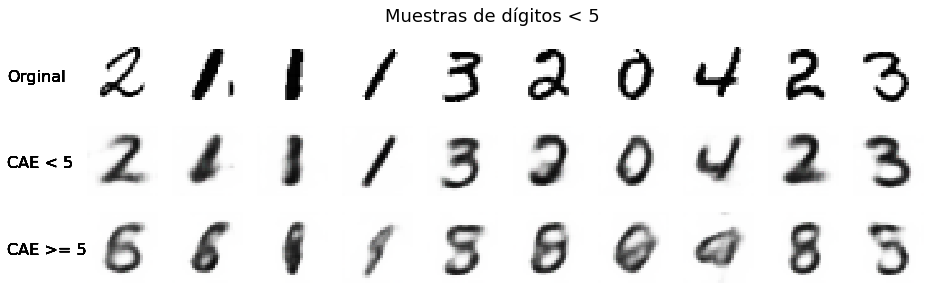

In [258]:
N = 10
i = 0
f, ax = plt.subplots(ncols=N, nrows=3, figsize=(1.5*N, 4.5))
f.suptitle('Muestras de dígitos < 5', fontsize=18)

for data in test_sub_5_generator:

    img = data[0][0]
    img_pred_over_5 = cae_over_5.model.predict(data[0])[0]
    err_over_5 = cae_over_5.model.evaluate(data[0], data[0], verbose=0)
    
    img_pred_sub_5 = cae_sub_5.model.predict(data[0])[0]
    err_sub_5 = cae_sub_5.model.evaluate(data[0], data[0], verbose=0)

    
    ax[0][i].imshow(img), ax[0][i].axis('off')
    ax[1][i].imshow(img_pred_sub_5), ax[1][i].axis('off')
    ax[2][i].imshow(img_pred_over_5), ax[2][i].axis('off')
    
    ax[0][0].text(-32, 16, 'Orginal', fontsize=16)
    ax[1][0].text(-32, 16, 'CAE < 5', fontsize=16)
    ax[2][0].text(-32, 16, 'CAE >= 5', fontsize=16)


    i += 1
    if i >= N:
        break

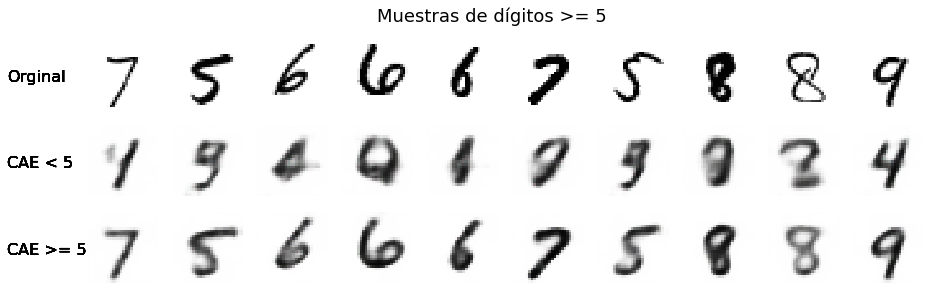

In [257]:
N = 10
i = 0
f, ax = plt.subplots(ncols=N, nrows=3, figsize=(1.5*N, 4.5))
f.suptitle('Muestras de dígitos >= 5', fontsize=18)

for data in test_over_5_generator:

    img = data[0][0]
    img_pred_over_5 = cae_over_5.model.predict(data[0])[0]
    err_over_5 = cae_over_5.model.evaluate(data[0], data[0], verbose=0)
    
    img_pred_sub_5 = cae_sub_5.model.predict(data[0])[0]
    err_sub_5 = cae_sub_5.model.evaluate(data[0], data[0], verbose=0)

    
    ax[0][i].imshow(img), ax[0][i].axis('off')
    ax[1][i].imshow(img_pred_sub_5), ax[1][i].axis('off')
    ax[2][i].imshow(img_pred_over_5), ax[2][i].axis('off')

    ax[0][0].text(-32, 16, 'Orginal', fontsize=16)
    ax[1][0].text(-32, 16, 'CAE < 5', fontsize=16)
    ax[2][0].text(-32, 16, 'CAE >= 5', fontsize=16)


    i += 1
    if i >= N:
        break